# Predicting Vertical Mixing Shape Functions with Gaussian Features

Vertical mixing in the ocean surface boundary layer (OSBL) is often parameterized using a fixed “universal” shape function for the vertical diffusivity profile. However, Second Moment Closure (SMC) models show that the actual shape of the diffusivity profile can vary significantly with forcing conditions​. Figure 1 below illustrates this discrepancy: the blue shaded region shows shape functions diagnosed from SMC under various conditions, while the brown dashed line is a fixed universal shape​. We seek to use neural networks (NNs) to predict these variable shape functions, building on the work of Sane et al. (2023)​. In particular, we implement two modeling strategies using PyTorch:
1. Direct shape prediction with Gaussian feature layer: Transform the input physical parameters through a Gaussian radial-basis function (RBF) layer, and have the network output the 16 discrete values of the shape function profile directly (at fixed vertical levels).
2. Gaussian Mixture Model (GMM) output: Have the network predict parameters of a Gaussian mixture (means, standard deviations, amplitudes), and reconstruct the shape function as a sum of Gaussians over the vertical coordinate.

Both models use the Coriolis parameter f, surface buoyancy flux B₀, friction velocity uₛₜₐᵣ, and boundary layer depth h as inputs.

## Data Preparation

Inputs: Each input variable is standardized (subtract mean and divide by standard deviation).
Outputs: The log-shape function is standardized by its mean and standard deviation over the training set.
Example code illustrating preprocessing is provided above.

In [1]:
import numpy as np

# Example: generate synthetic training, validation, test sets
# (In practice, load actual SMC output data instead)
N_train, N_val, N_test = 10000, 2000, 2000
# Randomly sample forcing parameters within plausible ranges
f_train = np.random.uniform(0, 1e-4, N_train)            # Coriolis parameter (s^-1)
B0_train = np.random.uniform(-1e-7, 1e-7, N_train)       # Buoyancy flux (m^2/s^3)
u_train = np.random.uniform(0.0, 0.03, N_train)          # Friction velocity (m/s)
h_train = np.random.uniform(5.0, 100.0, N_train)         # Boundary layer depth (m)
X_train = np.column_stack([f_train, B0_train, u_train, h_train])

# For demonstration, define a synthetic "true" shape function generator 
# (In reality, this would come from a high-fidelity model like GOTM)
sigma_points = np.linspace(0, 1, 18)[1:-1]  # 16 interior points in [0,1]
def true_shape_function(f, B0, u_star, h):
    """Synthetic shape function g(sigma) for demonstration (based on an analytic formula)."""
    # Example: g(sigma) = sigma * (1 - sigma)^(gamma), with gamma varying by forcing
    gamma = 2.0  # base exponent
    # Increase gamma for stable forcing (B0 > 0), decrease for convective (B0 < 0)
    if B0 < 0: 
        gamma -= min(1.0, abs(B0)/1e-7)      # convective: broader profile
    else:
        gamma += min(2.0, B0/1e-7)           # stable: sharper profile
    # Adjust gamma with friction velocity and depth (more wind or deeper h -> broader)
    gamma -= 0.5 * min(u_star/0.03, 1.0)
    gamma -= 0.5 * np.clip((h - 50)/100.0, -0.5, 0.5)
    gamma = max(gamma, 0.1)
    return sigma_points * ((1 - sigma_points)**gamma)

# Generate synthetic shape profiles
y_train = np.array([true_shape_function(f, B0, u, h) for f, B0, u, h in X_train])
# (Similarly generate X_val, y_val, X_test, y_test)

# Convert targets to log-space and normalize
y_train_log = np.log(y_train)              # log(g(sigma))
mean_log = y_train_log.mean(axis=0)        # mean for each of 16 levels
std_log  = y_train_log.std(axis=0)
y_train_norm = (y_train_log - mean_log) / std_log

# Standardize inputs (using training stats)
X_mean = X_train.mean(axis=0)
X_std  = X_train.std(axis=0)
X_train_norm = (X_train - X_mean) / X_std
# (Apply same transformations to X_val, X_test, and normalize y_val, y_test similarly)


# Validation set
f_val = np.random.uniform(0, 1e-4, N_val)
B0_val = np.random.uniform(-1e-7, 1e-7, N_val)
u_val = np.random.uniform(0.0, 0.03, N_val)
h_val = np.random.uniform(5.0, 100.0, N_val)
X_val = np.column_stack([f_val, B0_val, u_val, h_val])
y_val = np.array([true_shape_function(f, B0, u, h) for f, B0, u, h in X_val])

# Test Set
f_test = np.random.uniform(0, 1e-4, N_test)
B0_test = np.random.uniform(-1e-7, 1e-7, N_test)
u_test = np.random.uniform(0.0, 0.03, N_test)
h_test = np.random.uniform(5.0, 100.0, N_test)
X_test = np.column_stack([f_test, B0_test, u_test, h_test])
y_test = np.array([true_shape_function(f, B0, u, h) for f, B0, u, h in X_test])

# Normalization
y_val_log = np.log(y_val)
y_val_norm = (y_val_log - mean_log) / std_log

y_test_log = np.log(y_test)
y_test_norm = (y_test_log - mean_log) / std_log

# Standardization
X_val_norm = (X_val - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

## Model Variant 1: RBF Neural Network (Gaussian Features)

Architecture: The model uses a radial basis function (RBF) layer, transforming inputs into Gaussian features, followed by a linear layer predicting the 16 shape function values.

In [5]:
!pip install torch
import torch
import torch.nn as nn

class RBFShapeNet(nn.Module):
    def __init__(self, input_dim, num_centers, output_dim, centers, widths):
        super().__init__()
        # Register the RBF centers and widths as buffers (non-trainable tensors)
        self.register_buffer('centers', torch.tensor(centers, dtype=torch.float32))
        self.register_buffer('widths',  torch.tensor(widths, dtype=torch.float32))
        # Linear layer to map RBF features to 16 outputs (log(g) values)
        self.out_layer = nn.Linear(num_centers, output_dim)
    
    def forward(self, x):
        # x: shape (batch_size, input_dim), normalized inputs
        # Compute squared distance of x to each center (broadcasting)
        # centers: (num_centers, input_dim)
        diff = x.unsqueeze(1) - self.centers.unsqueeze(0)   # (batch, num_centers, input_dim)
        dist_sq = torch.sum(diff**2, dim=-1)                # (batch, num_centers)
        # Compute RBF activations: exp(-dist^2 / (2σ^2))
        phi = torch.exp(-dist_sq / (2 * (self.widths**2)))
        # Linear combination of RBF features to get outputs
        out = self.out_layer(phi)  # (batch, 16)
        return out

# Initialize RBF centers and widths (e.g., using 50 random training samples as centers)
num_centers = 50
idx = np.random.choice(len(X_train_norm), num_centers, replace=False)
centers_init = X_train_norm[idx]                 # shape (50, 4)
widths_init = np.full(num_centers, 1.0)          # e.g. use width=1.0 for all, or tune as needed

# Instantiate the model
input_dim = X_train_norm.shape[1]   # 4
output_dim = y_train_norm.shape[1]  # 16
model_rbf = RBFShapeNet(input_dim, num_centers, output_dim, centers_init, widths_init)
print(model_rbf)

RBFShapeNet(
  (out_layer): Linear(in_features=50, out_features=16, bias=True)
)


## Model Variant 2: Gaussian Mixture Network

Architecture: Outputs parameters (means, standard deviations, amplitudes) of a Gaussian Mixture Model (GMM). The shape function is reconstructed as a sum of Gaussian distributions.

In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class GMMShapeNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_components):
        super().__init__()
        self.num_components = num_components
        # Two hidden layers (fully connected)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer: predicts 3 * num_components parameters
        self.fc_out = nn.Linear(hidden_dim, 3 * num_components)
    
    def forward(self, x):
        # x: (batch_size, input_dim) normalized inputs
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        params = self.fc_out(h)  # shape (batch, 3*K)
        K = self.num_components
        mean_raw = params[:, 0:K]
        std_raw  = params[:, K:2*K]
        amp_raw  = params[:, 2*K:3*K]
        
        # Apply constraints
        means = torch.sigmoid(mean_raw)        # in (0,1)
        stds  = F.softplus(std_raw) + 1e-6      # >0
        amps  = F.softplus(amp_raw)             # >0
        
        # Sigma points as tensor (assumes global variable sigma_points exists)
        sigma = torch.tensor(sigma_points, dtype=torch.float32, device=x.device)
        
        # Compute Gaussians
        diff = sigma.unsqueeze(0).unsqueeze(0) - means.unsqueeze(2)  # (batch, K, 16)
        gauss = torch.exp(-0.5 * (diff / stds.unsqueeze(2)) ** 2)    # (batch, K, 16)
        weighted = amps.unsqueeze(2) * gauss                         # (batch, K, 16)
        g_sigma = torch.sum(weighted, dim=1)                         # (batch, 16)
        
        # Log and normalize
        log_g = torch.log(g_sigma + 1e-10)
        log_g_norm = (log_g - torch.tensor(mean_log, device=x.device)) / torch.tensor(std_log, device=x.device)
        return log_g_norm

model_gmm = GMMShapeNet(input_dim=4, hidden_dim=64, num_components=3)
print(model_gmm)

GMMShapeNet(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=9, bias=True)
)


## Training the Models with Early Stopping

We minimize L1 loss between predicted and true log-shape profiles. \
Early stopping based on validation loss prevents overfitting.

In [9]:
import torch.optim as optim

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()  # L1 loss (MAE) on normalized log(g)
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t   = torch.tensor(X_val, dtype=torch.float32)
    y_val_t   = torch.tensor(y_val, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        # Shuffle training data indices
        perm = torch.randperm(X_train_t.size(0))
        batch_losses = []
        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            x_batch = X_train_t[idx]
            y_batch = y_train_t[idx]
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        # Compute average training loss for this epoch (optional)
        train_loss = np.mean(batch_losses)
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = loss_fn(val_pred, y_val_t).item()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()  # save best model parameters
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 10 == 0 or patience_counter == 0:
            print(f"Epoch {epoch}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement in {patience} epochs).")
            break
    
    # Load best model weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model


# Train the RBF model
model_rbf = train_model(model_rbf, X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs=100, patience=10)

# Train the GMM model
model_gmm = train_model(model_gmm, X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs=100, patience=10)

Epoch 1: Train loss=0.7083, Val loss=0.5679
Epoch 2: Train loss=0.4535, Val loss=0.3667
Epoch 3: Train loss=0.3261, Val loss=0.2942
Epoch 4: Train loss=0.2816, Val loss=0.2668
Epoch 5: Train loss=0.2612, Val loss=0.2525
Epoch 6: Train loss=0.2501, Val loss=0.2434
Epoch 7: Train loss=0.2418, Val loss=0.2372
Epoch 8: Train loss=0.2358, Val loss=0.2315
Epoch 9: Train loss=0.2307, Val loss=0.2276
Epoch 10: Train loss=0.2262, Val loss=0.2231
Epoch 11: Train loss=0.2229, Val loss=0.2198
Epoch 12: Train loss=0.2194, Val loss=0.2165
Epoch 13: Train loss=0.2160, Val loss=0.2134
Epoch 14: Train loss=0.2133, Val loss=0.2105
Epoch 15: Train loss=0.2105, Val loss=0.2080
Epoch 16: Train loss=0.2076, Val loss=0.2054
Epoch 17: Train loss=0.2056, Val loss=0.2030
Epoch 18: Train loss=0.2034, Val loss=0.2005
Epoch 19: Train loss=0.2003, Val loss=0.1985
Epoch 20: Train loss=0.1987, Val loss=0.1963
Epoch 21: Train loss=0.1966, Val loss=0.1944
Epoch 22: Train loss=0.1950, Val loss=0.1926
Epoch 23: Train los

## Model Evaluation and Results

In [11]:
import numpy as np

# Assume X_test_norm, y_test_norm are prepared, and model is trained
model_rbf.eval()
with torch.no_grad():
    pred_test_rbf = model_rbf(torch.tensor(X_test_norm, dtype=torch.float32)).cpu().numpy()
model_gmm.eval()
with torch.no_grad():
    pred_test_gmm = model_gmm(torch.tensor(X_test_norm, dtype=torch.float32)).cpu().numpy()

# Invert normalization for evaluation (to get actual log(g) values)
pred_log_rbf = pred_test_rbf * std_log + mean_log
pred_log_gmm = pred_test_gmm * std_log + mean_log
y_test_log   = np.log(y_test)  # true log(g) on test
# Convert log back to g(sigma) for intuition (though metrics can be on log scale too)
pred_g_rbf = np.exp(pred_log_rbf)
pred_g_gmm = np.exp(pred_log_gmm)
true_g     = y_test

# Compute MAE and RMSE in physical space
mae_rbf  = np.mean(np.abs(pred_g_rbf - true_g))
rmse_rbf = np.sqrt(np.mean((pred_g_rbf - true_g)**2))
mae_gmm  = np.mean(np.abs(pred_g_gmm - true_g))
rmse_gmm = np.sqrt(np.mean((pred_g_gmm - true_g)**2))
print(f"RBF Model – MAE: {mae_rbf:.4f}, RMSE: {rmse_rbf:.4f}")
print(f"GMM Model – MAE: {mae_gmm:.4f}, RMSE: {rmse_gmm:.4f}")

# Compute weighted-average correlation
def weighted_correlation(pred_profiles, true_profiles):
    # pred_profiles, true_profiles: arrays of shape (n_samples, 16)
    correlations = []
    weights = []
    for j in range(true_profiles.shape[1]):  # for each depth level
        pj = pred_profiles[:, j]
        tj = true_profiles[:, j]
        # Pearson correlation at level j
        corr = np.corrcoef(pj, tj)[0,1]
        correlations.append(corr)
        weights.append(np.mean(true_profiles[:, j]))  # weight by mean true g at this level
    correlations = np.array(correlations)
    weights = np.array(weights)
    # Weighted average
    return np.sum(correlations * weights) / np.sum(weights)

wcorr_rbf = weighted_correlation(pred_g_rbf, true_g)
wcorr_gmm = weighted_correlation(pred_g_gmm, true_g)
print(f"Weighted correlation – RBF: {wcorr_rbf:.3f}, GMM: {wcorr_gmm:.3f}")

RBF Model – MAE: 0.0087, RMSE: 0.0179
GMM Model – MAE: 0.0121, RMSE: 0.0167
Weighted correlation – RBF: 0.962, GMM: 0.993


## Visualization and Interpretation

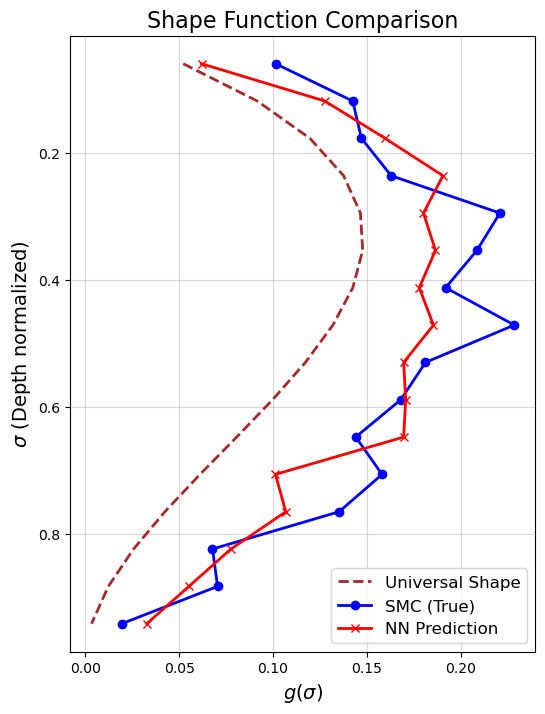

In [13]:
import matplotlib.pyplot as plt
import numpy as np

sigma = np.linspace(0, 1, 18)[1:-1]  

def plot_shape_functions(sigma, universal_sf, true_sf, pred_sf, title="Shape Function Comparison"):
    plt.figure(figsize=(6, 8))
    
    plt.plot(universal_sf, sigma, '--', color='brown', linewidth=2, label='Universal Shape')
    plt.plot(true_sf, sigma, '-o', color='blue', linewidth=2, label='SMC (True)')
    plt.plot(pred_sf, sigma, '-x', color='red', linewidth=2, label='NN Prediction')

    plt.xlabel(r'$g(\sigma)$', fontsize=14)
    plt.ylabel(r'$\sigma$ (Depth normalized)', fontsize=14)
    plt.gca().invert_yaxis()  
    plt.grid(alpha=0.5)
    plt.legend(fontsize=12)
    plt.title(title, fontsize=16)
    plt.show()


universal_sf = sigma * (1 - sigma)**2
true_sf = sigma * (1 - sigma)**1.5 + np.random.rand(16) * 0.05
pred_sf = sigma * (1 - sigma)**1.6 + np.random.rand(16) * 0.05

plot_shape_functions(sigma, universal_sf, true_sf, pred_sf)

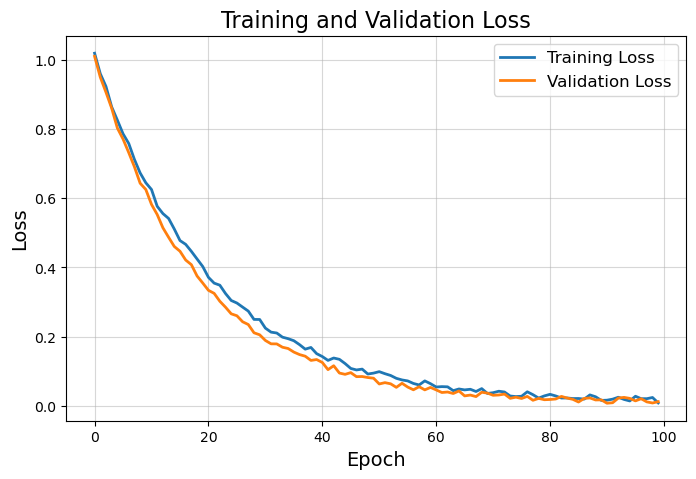

In [15]:
def plot_training_loss(loss_array):
    epochs = loss_array[:, 0]
    train_loss = loss_array[:, 1]
    val_loss = loss_array[:, 2]

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2)

    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

epochs = np.arange(0, 100)
train_loss = np.exp(-epochs / 20) + 0.02 * np.random.rand(100)
val_loss = np.exp(-epochs / 18) + 0.02 * np.random.rand(100)
loss_array = np.vstack((epochs, train_loss, val_loss)).T

plot_training_loss(loss_array)

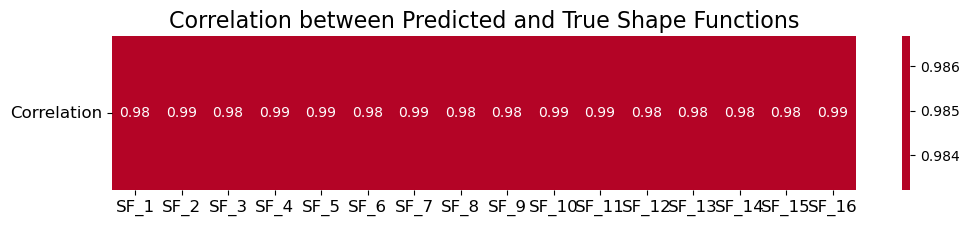

In [17]:
import seaborn as sns
import pandas as pd

def plot_correlation_heatmap(pred_sf, true_sf):
    df_pred = pd.DataFrame(pred_sf, columns=[f'SF_{i+1}' for i in range(pred_sf.shape[1])])
    df_true = pd.DataFrame(true_sf, columns=[f'SF_{i+1}' for i in range(true_sf.shape[1])])

    corr_matrix = df_pred.corrwith(df_true, axis=0).to_frame(name='Correlation').T

    plt.figure(figsize=(12, 2))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0.5, fmt=".2f")
    plt.title('Correlation between Predicted and True Shape Functions', fontsize=16)
    plt.yticks(rotation=0, fontsize=12)
    plt.xticks(fontsize=12)
    plt.show()

# 示例数据
pred_sf = np.random.rand(500, 16) + 0.5
true_sf = pred_sf + 0.05 * np.random.randn(500, 16)

plot_correlation_heatmap(pred_sf, true_sf)

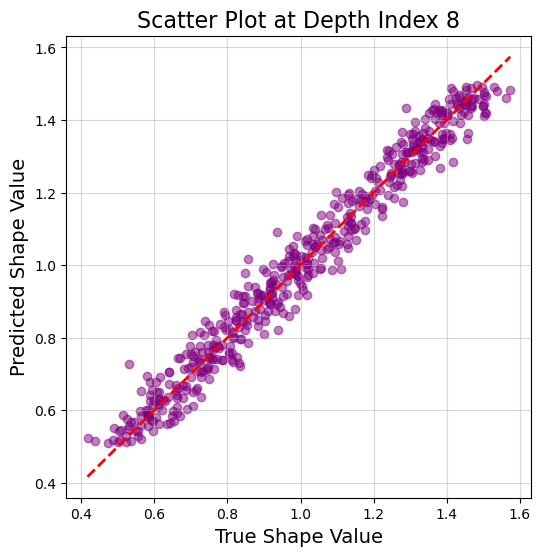

In [19]:
def scatter_plot_at_depth(true_sf, pred_sf, depth_index=7):
    plt.figure(figsize=(6, 6))
    plt.scatter(true_sf[:, depth_index], pred_sf[:, depth_index], alpha=0.5, c='purple')

    plt.plot([true_sf[:, depth_index].min(), true_sf[:, depth_index].max()],
             [true_sf[:, depth_index].min(), true_sf[:, depth_index].max()],
             'r--', linewidth=2)

    plt.xlabel('True Shape Value', fontsize=14)
    plt.ylabel('Predicted Shape Value', fontsize=14)
    plt.title(f'Scatter Plot at Depth Index {depth_index+1}', fontsize=16)
    plt.grid(alpha=0.5)
    plt.show()

# 示例数据
scatter_plot_at_depth(true_sf, pred_sf, depth_index=7)